In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os, sys
import pyedflib
import urllib.request
from tqdm import tqdm
from scipy import io
from math import sqrt
from pyedflib import highlevel

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

In [2]:
MMI_SUBJECT = 109
MMI_TRIAL = 14
MMI_CHANNEL = 64
MMI_SEQ_LEN = 20 
MMI_COR_LEN = 8

# DATA PREPROCESS & SAVE

In [3]:
file_path='./eegmmidb_edf/S'
save_path='./eegmmidb_feature/S'

MMI_right_hand = np.zeros((144,64,64))
MMI_left_hand = np.zeros((144,64,64))
MMI_both_hand = np.zeros((144,64,64))
MMI_both_feet = np.zeros((144,64,64))

                        
for i in tqdm(range(MMI_SUBJECT)):
    single_right_hand = []
    single_left_hand = []
    single_both_hand = []
    single_both_feet = []
    for j in range(2, MMI_TRIAL):
        path = file_path+str(i+1).zfill(3)+'/s'+str(i+1).zfill(3)+'R'+str(j+1).zfill(2)+'.edf'
        signals, signal_header, header = highlevel.read_edf(path)
        labels = header['annotations']

        if (j==2 or j==3 or j==6 or j==7 or j==10 or j==11):
            for label in labels:
                start_point = int(label[0]*160)
                dur = 4
                k = int(dur*160/20)
                if label[2] == 'T1': #left fist
                    for m in range(k):
                        temp = signals[:,start_point+m*20:start_point+(m+1)*20]
                        temp = np.nanmean(temp, axis=1)
                        single_left_hand.append(temp)
            
                elif label[2] == 'T2': #right fist
                    for m in range(k):
                        temp = signals[:,start_point+m*20:start_point+(m+1)*20]
                        temp = np.nanmean(temp, axis=1)
                        single_right_hand.append(temp)
                    
        elif (j==4 or j==5 or j==8 or j==9 or j==12 or j==13):
            for label in labels:
                start_point = int(label[0]*160)
                dur = 4
                k = int(dur*160/20)
                if label[2] == 'T1': #both fist
                    for m in range(k):
                        temp = signals[:,start_point+m*20:start_point+(m+1)*20]
                        temp = np.nanmean(temp, axis=1)
                        single_both_hand.append(temp)

                elif label[2] == 'T2': #both feet
                    for m in range(k):
                        temp = signals[:,start_point+m*20:start_point+(m+1)*20]
                        temp = np.nanmean(temp, axis=1)
                        single_both_feet.append(temp)
                            
    single_left_hand = np.array(single_left_hand)
    single_right_hand = np.array(single_right_hand)
    single_both_hand = np.array(single_both_hand)   
    single_both_feet = np.array(single_both_feet)

    for m in range(144):
        MMI_left_hand[m,:,:] = np.corrcoef(single_left_hand[m*MMI_COR_LEN:(m+1)*MMI_COR_LEN,:], rowvar=False) 
        MMI_right_hand[m,:,:] = np.corrcoef(single_right_hand[m*MMI_COR_LEN:(m+1)*MMI_COR_LEN,:], rowvar=False)
        MMI_both_hand[m,:,:] = np.corrcoef(single_both_hand[m*MMI_COR_LEN:(m+1)*MMI_COR_LEN,:], rowvar=False)        
        MMI_both_feet[m,:,:] = np.corrcoef(single_both_feet[m*MMI_COR_LEN:(m+1)*MMI_COR_LEN,:], rowvar=False)
    path = save_path+str(i+1).zfill(3) 
    np.save(path+'/Left_hand', MMI_left_hand) #저장할때만
    np.save(path+'/Right_hand', MMI_right_hand)
    np.save(path+'/Both_hand', MMI_both_hand) 
    np.save(path+'/Both_feet', MMI_both_feet) 

 80%|████████████████████████████████████████████████████████████████▋                | 87/109 [03:41<00:54,  2.50s/it]C:\Users\jae\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
C:\Users\jae\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
C:\Users\jae\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
C:\Users\jae\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice
100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [04:34<00:00,  2.52s/it]


# LOAD DATA & SEPERATE

In [4]:
load_path = './eegmmidb_feature/S'
temp = []
MMI_left_hand = []
MMI_right_hand = []
MMI_both_hand = []
MMI_both_feet = []
MMI_channel_wise = []

for i in range(MMI_SUBJECT):
    if i==87 or i==91 or i==99 or i==103 or i==105: continue
    path = load_path+str(i+1).zfill(3)
    temp = np.load(path+'/Left_hand.npy')
    MMI_left_hand.append(temp)
    temp = np.load(path+'/Right_hand.npy')
    MMI_right_hand.append(temp)
    temp = np.load(path+'/Both_hand.npy')
    MMI_both_hand.append(temp)
    temp = np.load(path+'/Both_feet.npy')
    MMI_both_feet.append(temp)
    
MMI_channel_wise.append(MMI_left_hand)
#MMI_left_hand = []
MMI_channel_wise.append(MMI_right_hand)
#MMI_right_hand = []
MMI_channel_wise.append(MMI_both_hand)
#MMI_both_hand = []
MMI_channel_wise.append(MMI_both_feet)
#MMI_both_feet = []
MMI_channel_wise = np.array(MMI_channel_wise)
print(MMI_channel_wise.shape)
MMI_channel_wise = MMI_channel_wise.reshape(-1,64,64,1)


label = np.zeros((len(MMI_channel_wise), 4))
for i in range(len(label)):
    k = int(i/(len(label)/4))
    label[i][k] = 1

print(MMI_channel_wise.shape)
print(label.shape)

(4, 104, 144, 64, 64)
(59904, 64, 64, 1)
(59904, 4)


In [5]:
idx = [i for i in range(len(MMI_channel_wise))]
np.random.shuffle(idx)
MMI_channel_wise = MMI_channel_wise[idx]
label = label[idx]

cutoff = int(len(MMI_channel_wise)*0.9)

train_data = MMI_channel_wise[:cutoff]
train_label = label[:cutoff]
test_data = MMI_channel_wise[cutoff:]
test_label = label[cutoff:]
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(53913, 64, 64, 1) (53913, 4)
(5991, 64, 64, 1) (5991, 4)


In [6]:
import keras
from keras.models import Model, Sequential
from keras.layers import Flatten, Reshape, Conv2D, Dense, Input, Activation
from keras.layers import Dropout, BatchNormalization, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


In [7]:
keras.backend.clear_session()

model = Sequential()
model.add(Conv2D(64, (1,64), activation='relu', input_shape=(64,64,1)))
model.add(Reshape((64,64,1)))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dense(4, activation='sigmoid'))

"""
inputs = Input(shape=(64,64,1))
x = Conv2D(64, (1,64), activation='relu')(inputs)
x = Reshape((64,64,1))(x)
x = Conv2D(8, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2D(8, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2D(8, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(2048, activation='relu')(x)
prediction = Dense(4, activation='sigmoid')(x)
"""

adam = Adam(learning_rate=0.0005)
#model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer=adam, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callback_list = [ModelCheckpoint(filepath='MMI_44.h5',
                                monitor='val_accuracy', save_best_only=True)]
              
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 1, 64)         4160      
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 8)         32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 8)         584       
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 8)        

In [ ]:
history = model.fit(train_data, train_label, epochs=50, batch_size = 100,
                   validation_data=(test_data, test_label), callbacks=callback_list, verbose=2)

Train on 53913 samples, validate on 5991 samples
Epoch 1/50
 - 31s - loss: 1.3867 - accuracy: 0.2499 - val_loss: 1.3863 - val_accuracy: 0.2505
Epoch 2/50
 - 26s - loss: 1.3864 - accuracy: 0.2499 - val_loss: 1.3863 - val_accuracy: 0.2505
Epoch 3/50


# TEST BLOCK

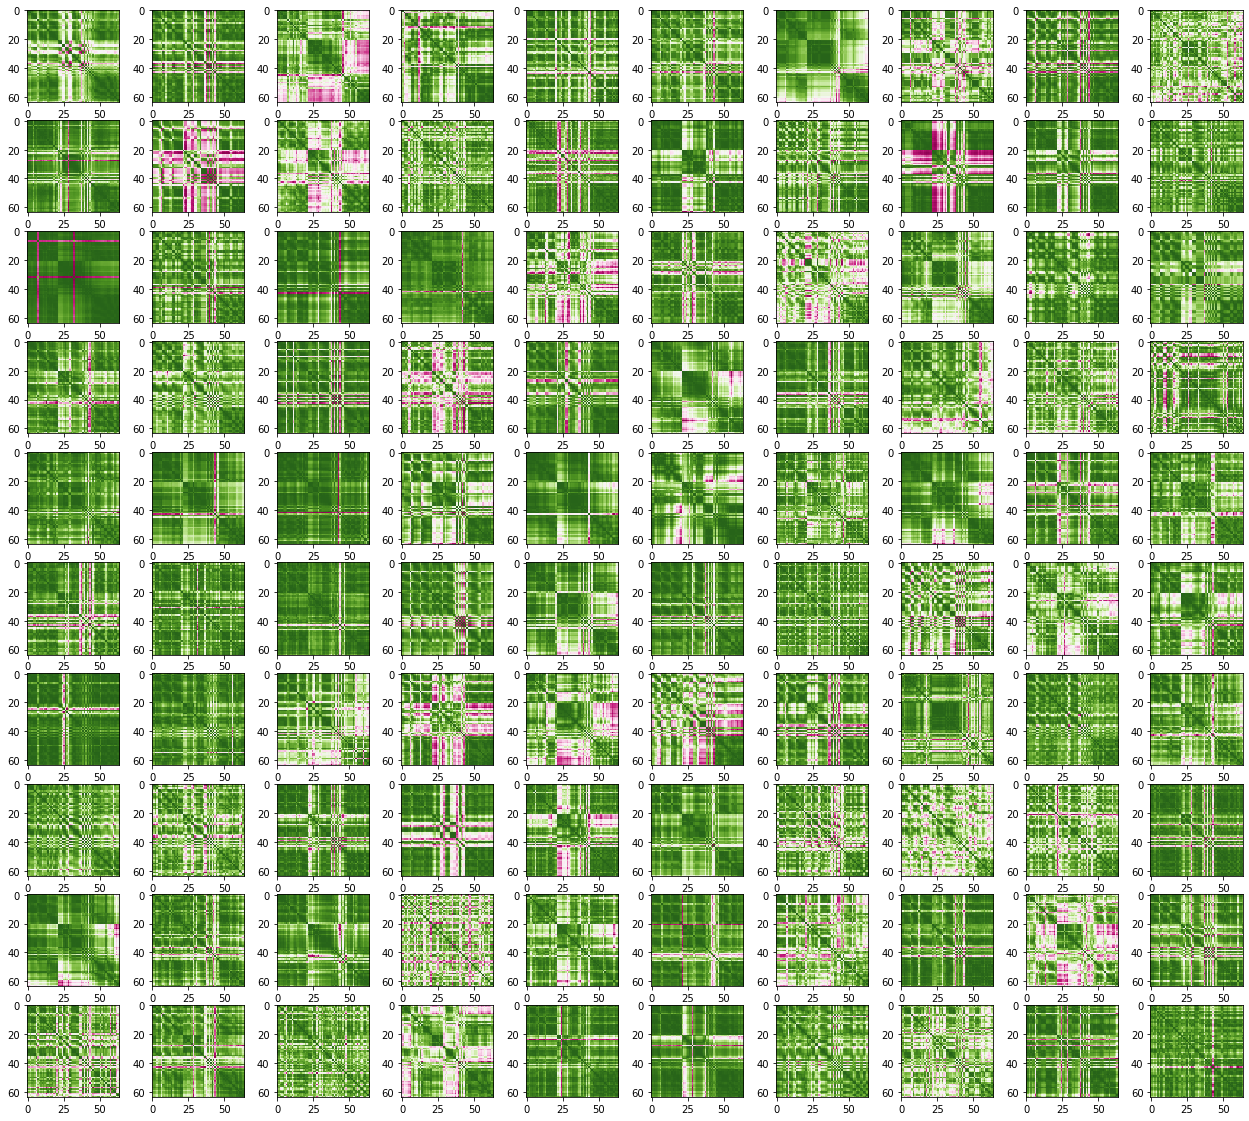

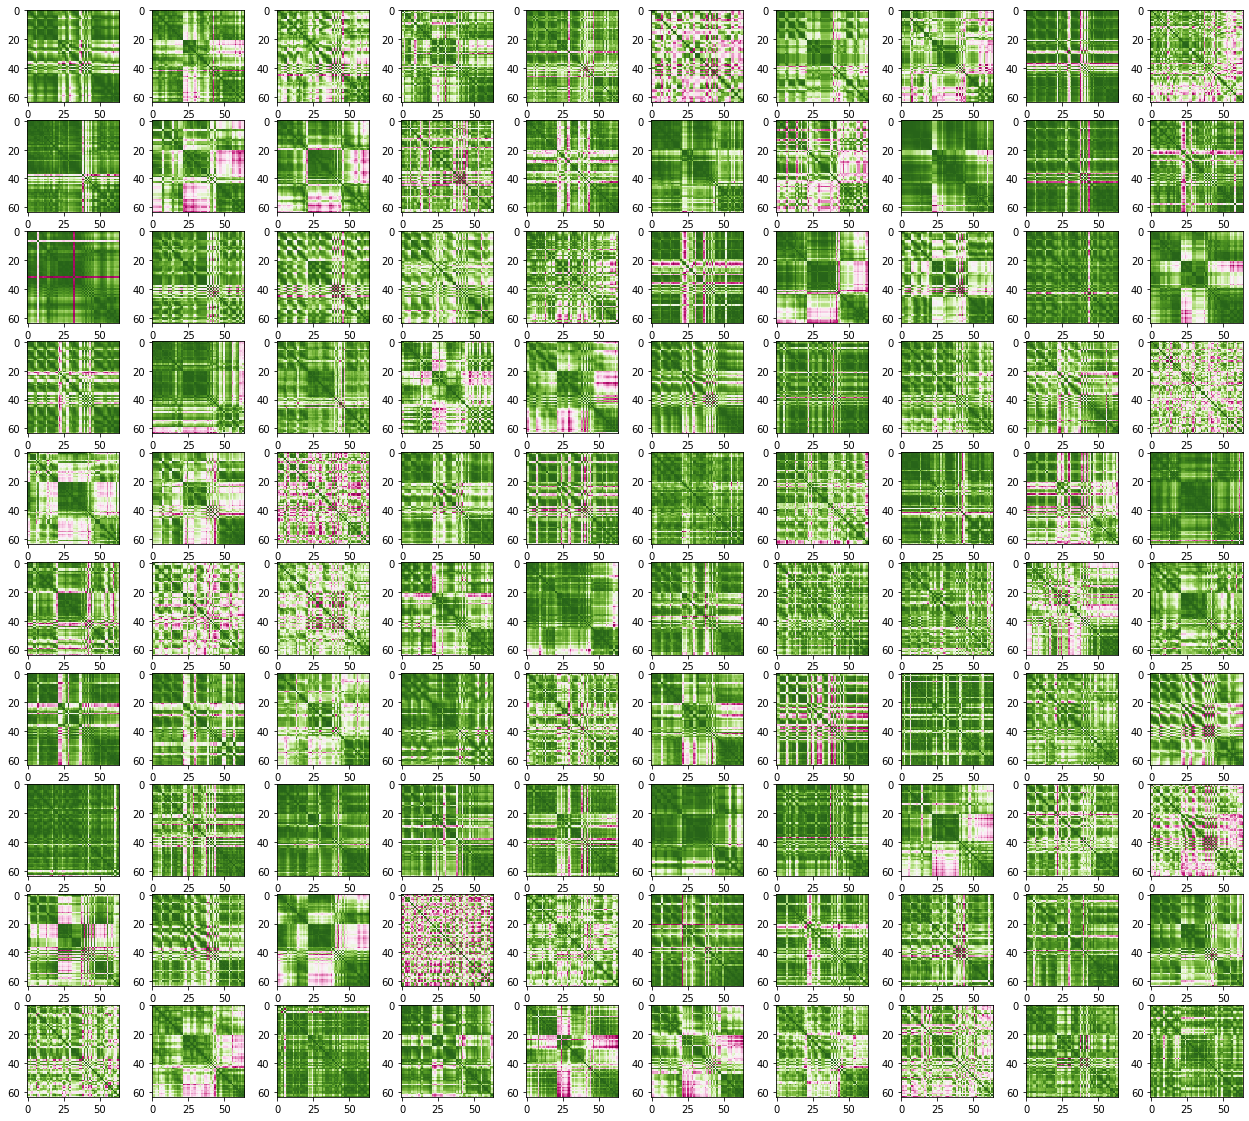

In [14]:
MMI_left_hand = np.array(MMI_left_hand)
MMI_right_hand = np.array(MMI_right_hand)

fig1 = plt.figure(figsize=(22,20))
plt.title('Left Hand')
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, 10*i+j+1)
        plt.imshow(MMI_left_hand[10*i+j,0,:,:], cmap='PiYG')

      
plt.figure(figsize=(22,20))
plt.title('Right Hand')
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, 10*i+j+1)
        plt.imshow(MMI_right_hand[10*i+j,0,:,:], cmap='PiYG')
#plt.savefig('right_hand.png',dpi=900)

In [64]:
#Error check
#88 92 100 104 106
file_path='./eegmmidb_edf/S'
for i in range(MMI_SUBJECT):
    for j in range(2, MMI_TRIAL) :
        path = file_path+str(i+1).zfill(3)+'/s'+str(i+1).zfill(3)+'R'+str(j+1).zfill(2)+'.edf'
        signals, signal_header, header = highlevel.read_edf(path)
        if signals.shape[1] < 18000:
            print(i+1 ,' : ',signals.shape)
        

88  :  (64, 15872)
88  :  (64, 15872)
88  :  (64, 15872)
88  :  (64, 15872)
88  :  (64, 15872)
88  :  (64, 15872)
88  :  (64, 15872)
88  :  (64, 15872)
88  :  (64, 15872)
88  :  (64, 15872)
88  :  (64, 15872)
88  :  (64, 15872)
92  :  (64, 15872)
92  :  (64, 15872)
92  :  (64, 15872)
92  :  (64, 15872)
92  :  (64, 15872)
92  :  (64, 15872)
92  :  (64, 15872)
92  :  (64, 15872)
92  :  (64, 15872)
92  :  (64, 15872)
92  :  (64, 15872)
92  :  (64, 15872)
100  :  (64, 15744)
100  :  (64, 15744)
100  :  (64, 15744)
100  :  (64, 15744)
100  :  (64, 15744)
100  :  (64, 15744)
100  :  (64, 15744)
100  :  (64, 15744)
100  :  (64, 15744)
100  :  (64, 15744)
100  :  (64, 15744)
100  :  (64, 15744)
104  :  (64, 16960)
106  :  (64, 5920)


# PYTORCH

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os, sys
import urllib.request
from tqdm import tqdm
from scipy import io

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
MMI_SUBJECT = 109
MMI_TRIAL = 14
MMI_CHANNEL = 64
MMI_SEQ_LEN = 20 
MMI_COR_LEN = 8

In [3]:
load_path = './eegmmidb_feature/S'
temp = []
MMI_left_hand = []
MMI_right_hand = []
MMI_both_hand = []
MMI_both_feet = []
MMI_channel_wise = []

for i in tqdm(range(MMI_SUBJECT)):
    if i==87 or i==91 or i==99 or i==103 or i==105: continue
    path = load_path+str(i+1).zfill(3)
    temp = np.load(path+'/Left_hand.npy')
    MMI_left_hand.append(temp)
    temp = np.load(path+'/Right_hand.npy')
    MMI_right_hand.append(temp)
    temp = np.load(path+'/Both_hand.npy')
    MMI_both_hand.append(temp)
    temp = np.load(path+'/Both_feet.npy')
    MMI_both_feet.append(temp)
    
MMI_channel_wise.append(MMI_left_hand)
#MMI_left_hand = []
MMI_channel_wise.append(MMI_right_hand)
#MMI_right_hand = []
MMI_channel_wise.append(MMI_both_hand)
#MMI_both_hand = []
MMI_channel_wise.append(MMI_both_feet)
#MMI_both_feet = []
MMI_channel_wise = np.array(MMI_channel_wise)
print(MMI_channel_wise.shape)
MMI_channel_wise = MMI_channel_wise.reshape(-1,64,64,1)
MMI_channel_wise = np.swapaxes(MMI_channel_wise, 1, 3)

label = np.zeros((len(MMI_channel_wise)))
for i in range(len(label)):
    k = int(i/(len(label)/4))
    label[i] = k

print(MMI_channel_wise.shape)
print(label.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 116.89it/s]


(4, 104, 144, 64, 64)
(59904, 1, 64, 64)
(59904,)


In [4]:
idx = [i for i in range(len(MMI_channel_wise))]
np.random.shuffle(idx)
MMI_channel_wise = MMI_channel_wise[idx]
label = label[idx]

cutoff = int(len(MMI_channel_wise)*0.9)

train_data = MMI_channel_wise[:cutoff]
train_label = label[:cutoff]
test_data = MMI_channel_wise[cutoff:]
test_label = label[cutoff:]
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(53913, 1, 64, 64) (53913,)
(5991, 1, 64, 64) (5991,)


In [5]:
x_train = torch.FloatTensor(train_data)
y_train = torch.LongTensor(train_label)

dataset= TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=50, shuffle=False)

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,64,(64,1))
        self.conv2 = nn.Conv2d(1,8,3)
        self.bn1 = nn.BatchNorm2d(62,62,8)
        self.dropout1 = nn.Dropout2d(0.4)
        self.conv3 = nn.Conv2d(8,8,3)
        self.bn2 = nn.BatchNorm2d(60,60,8)
        self.dropout2 = nn.Dropout2d(0.4)
        self.conv4 = nn.Conv2d(8,8,3)
        self.bn3 = nn.BatchNorm2d(58,58,8)
        self.dropout3 = nn.Dropout2d(0.4)
        self.fc1 = nn.Linear(58*58*8, 2048)
        self.fc2 = nn.Linear(2048, 4)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1,1,64,64)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 58*58*8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(64, 1), stride=(1, 1))
  (conv2): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(62, eps=62, momentum=8, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.4, inplace=False)
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(60, eps=60, momentum=8, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.4, inplace=False)
  (conv4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(58, eps=58, momentum=8, affine=True, track_running_stats=True)
  (dropout3): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=26912, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=4, bias=True)
)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0008, momentum=0.9)

In [26]:
for epoch in range(50):
    running_loss = 0.0
    
    for i, data in enumerate(dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        #print(outputs.size(), labels.size())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i% 500 == 499:
            print('[%d, %5d] loss : %.3f' %(epoch+1, i+1, running_loss/500))
            running_loss = 0.0
            
print('Finished Training')

[1,   500] loss : 1.386
[1,  1000] loss : 1.386
[2,   500] loss : 1.386
[2,  1000] loss : 1.386
[3,   500] loss : 1.386
[3,  1000] loss : 1.385
[4,   500] loss : 1.385
[4,  1000] loss : 1.384
[5,   500] loss : 1.384
[5,  1000] loss : 1.383
[6,   500] loss : 1.383
[6,  1000] loss : 1.382
[7,   500] loss : 1.382
[7,  1000] loss : 1.380
[8,   500] loss : 1.380
[8,  1000] loss : 1.379
[9,   500] loss : 1.378
[9,  1000] loss : 1.377
[10,   500] loss : 1.376
[10,  1000] loss : 1.375
[11,   500] loss : 1.373
[11,  1000] loss : 1.372
[12,   500] loss : 1.371
[12,  1000] loss : 1.370
[13,   500] loss : 1.368
[13,  1000] loss : 1.367
[14,   500] loss : 1.366
[14,  1000] loss : 1.365
[15,   500] loss : 1.363
[15,  1000] loss : 1.362
[16,   500] loss : 1.361
[16,  1000] loss : 1.360
[17,   500] loss : 1.359
[17,  1000] loss : 1.357
[18,   500] loss : 1.356
[18,  1000] loss : 1.354
[19,   500] loss : 1.353
[19,  1000] loss : 1.351
[20,   500] loss : 1.350
[20,  1000] loss : 1.348
[21,   500] loss :

In [27]:
x_test = torch.FloatTensor(test_data)
y_test = torch.LongTensor(test_label)

dataset= TensorDataset(x_test, y_test)
testloader = DataLoader(dataset, batch_size=50, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for data in dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        
print('Accuracy of the network on the train samples: %f %%' %(100*correct/total))

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the test samples: %f %%' %(100*correct/total))

Accuracy of the network on the train samples: 66.123198 %
Accuracy of the network on the test samples: 28.542814 %
